In [1]:
import numpy as np
import pandas as pd
import graspologic as gs
import seaborn as sns
import matplotlib.pyplot as plt

from graspologic.embed import AdjacencySpectralEmbed as ASE
from graspologic.simulations import sbm
from graspologic.utils import remove_vertices
from graspologic.plot import pairplot, heatmap

np.random.seed(9002)
np.set_printoptions(suppress=True)

# Make 2D

In [2]:
# create sbm
def graph(P, directed=False, diag_aug=False, reverse_pred=False, suppress_text=False, n=100, title=None):
    n_components = P.shape[0]
    ase = ASE(n_components=n_components, diag_aug=diag_aug)
    directed_g, labels = sbm([n]*n_components, P, 
                           return_labels=True, directed=directed)

    # generate labels
    oos_idx = np.nonzero(np.r_[1, np.diff(labels)[:-1]])[0]  # grab one from each community
    labels = list(labels)
    oos_labels = [labels.pop(i) for i in oos_idx]

    # grab oos indices
    A, a = remove_vertices(directed_g, indices=oos_idx, return_removed=True)
    if reverse_pred and directed:
        a = a[::-1]

    if directed:
        out_latent, in_latent = ase.fit_transform(A)
    else:
        out_latent = ase.fit_transform(A)

    w = ase.predict(a)
    
    if directed:
        out_w, in_w = w
    else:
        out_w = w

    # print results
    if not suppress_text:
        print(f"left latent positions (sample from same communities): \n{out_latent[oos_idx, :]}\n")
        print(f"left prediction: \n{out_w}\n\n")
        
        if directed:
            print(f"right latent positions (sample from same communities): \n{in_latent[oos_idx, :]}\n")
            print(f"right prediction: \n{in_w}")
    
    # labels dataframes
    df_labels = pd.DataFrame(labels, columns=["Type"])
    df_oos_labels = pd.DataFrame(oos_labels, columns=["Type"])

    # out dataframes
    out_oos_df = pd.concat([  df_oos_labels, pd.DataFrame(out_w)], axis=1)
    out_oos_df.columns = ["Type"]+[f"Dimension {d+1}" for d in range(P.shape[0])]

    g = pairplot(out_latent, labels=labels, title=title)
    g.data = out_oos_df
    g.hue_vals = out_oos_df["Type"]
    g.map_offdiag(plt.scatter, s=500, marker="*", edgecolor="black")

## with first array

left latent positions (sample from same communities): 
[[ 0.71505795 -0.57751888]
 [ 0.61686268  0.55151876]]

left prediction: 
[[ 0.72642811 -0.50738069]
 [ 0.71544086  0.55606625]]




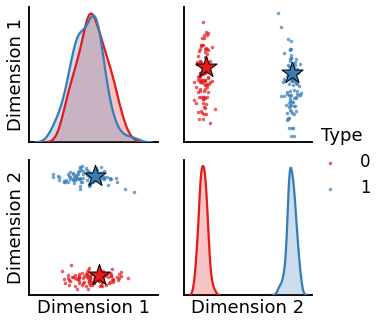

In [3]:
P = np.array([[0.8, 0.2],
              [0.2, 0.8]])

graph(P)

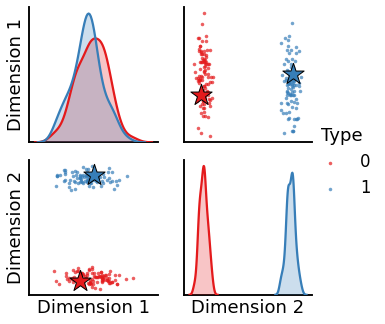

In [4]:
graph(P, reverse_pred=True, suppress_text=True)

In [5]:
P.shape[0]
[f"Dimension {d+1}" for d in range(P.shape[0])]

['Dimension 1', 'Dimension 2']

## with second array

anton says: if it aint positive semidefinite, it aint gon work

left latent positions (sample from same communities): 
[[ 0.72091912  0.46947455]
 [ 0.66406713 -0.57951103]]

left prediction: 
[[ 0.75893427 -0.56625217]
 [ 0.66857665  0.58123015]]




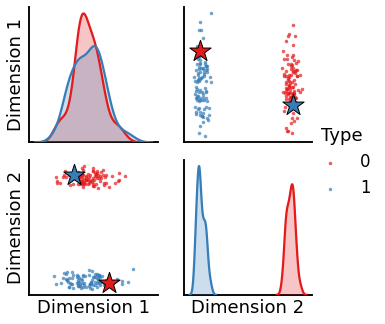

In [6]:
P = np.array([[0.2, 0.8],
              [0.8, 0.2]])

graph(P, directed=False)

left latent positions (sample from same communities): 
[[ 0.73443696  0.59381267]
 [ 0.7078486  -0.56856934]]

left prediction: 
[[ 0.7328344  -0.55970563]
 [ 0.73935307  0.70266501]]


right latent positions (sample from same communities): 
[[ 0.62277208 -0.46935583]
 [ 0.72194854  0.44903694]]

right prediction: 
[[ 0.69421189  0.60598385]
 [ 0.79059646 -0.50329558]]


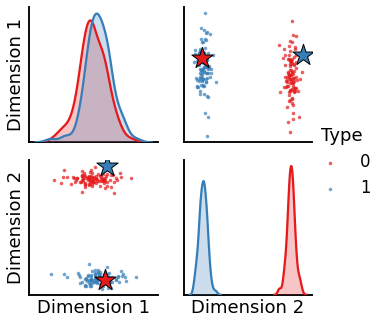

In [7]:
graph(P, directed=True)

In [8]:
# its because there's a negative eigenvalue
np.linalg.eig(P)

(array([ 1. , -0.6]),
 array([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]]))

## 3D

#### undirected case

(array([1.05877415, 0.3810466 , 0.56017926]), array([[-0.77024208, -0.55903255, -0.30693606],
       [-0.56721933,  0.82050111, -0.07099407],
       [-0.29152938, -0.11941745,  0.94907855]]))


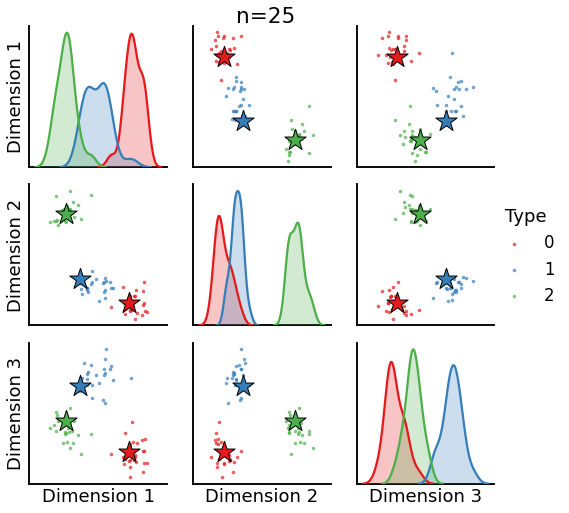

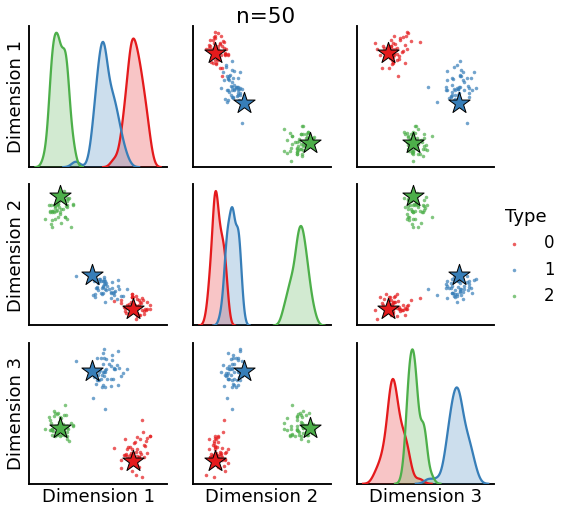

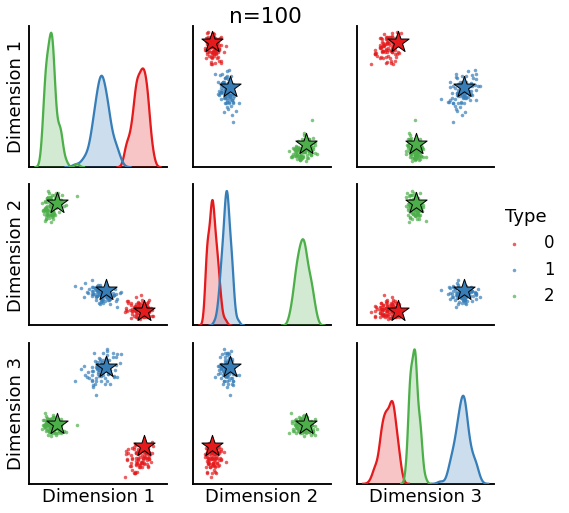

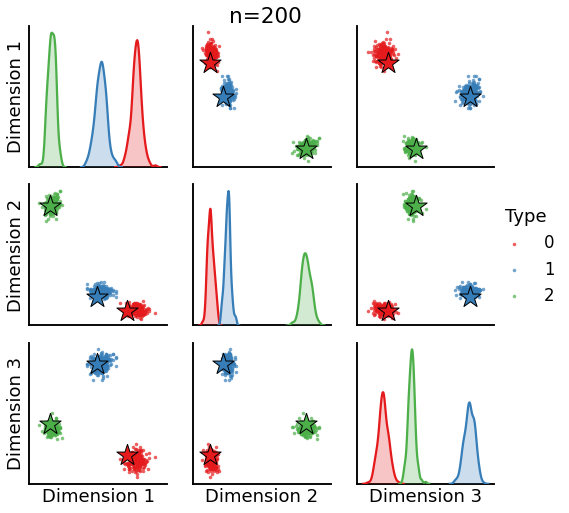

In [9]:
P = np.array([[0.8, 0.3, 0.1], 
              [0.3, 0.6, 0.1], 
              [0.1, 0.1, 0.6]])

# P = np.array([[0.9, 0.1, 0.1], 
#               [0.3, 0.6, 0.1], 
#               [0.1, 0.5, 0.6]])


for n in [25, 50, 100, 200]:
    graph(P, directed=False, diag_aug=True, suppress_text=True, n=n, title=f"n={n}")
    
print(np.linalg.eig(P))

#### directed case

(array([1.08844837, 0.58842506, 0.42312657]), array([[-0.59752807, -0.31739708, -0.13330639],
       [-0.49598508,  0.04154763, -0.30671662],
       [-0.63004683,  0.94738212,  0.9424194 ]]))


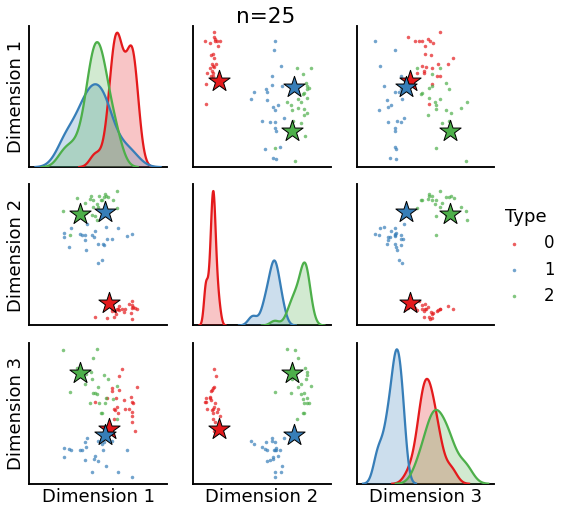

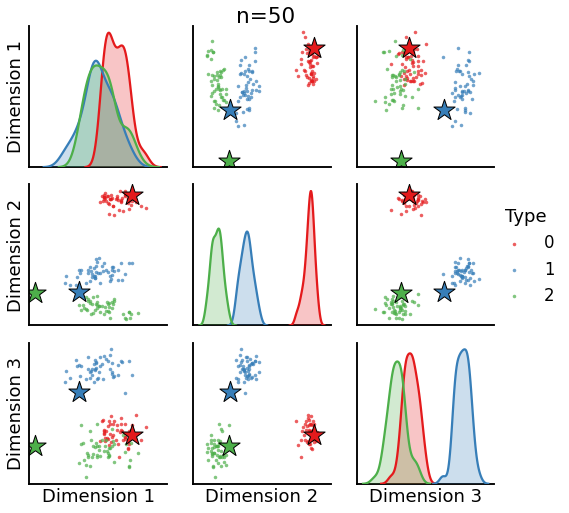

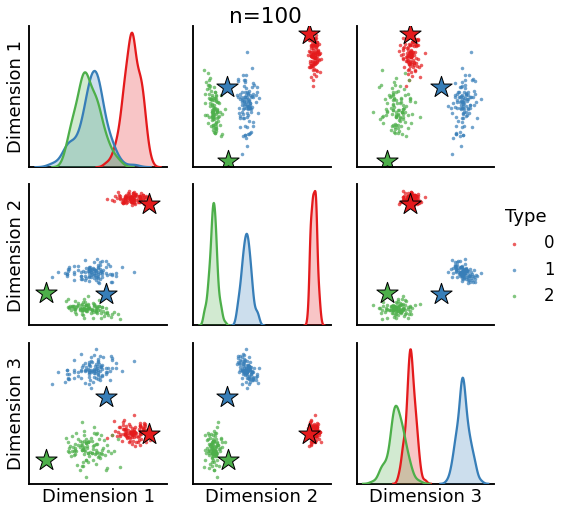

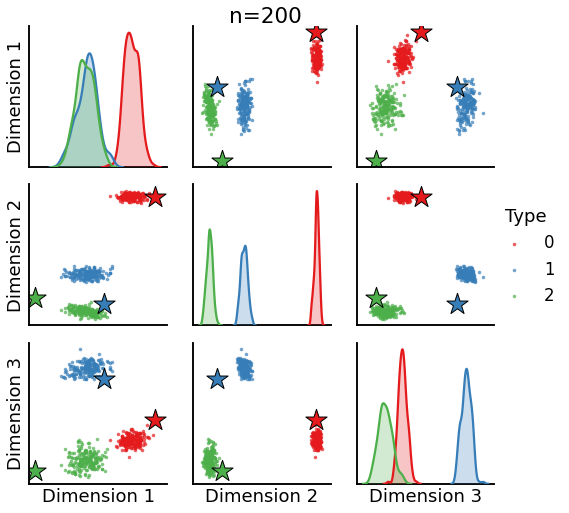

In [10]:
# P = np.array([[0.8, 0.3, 0.1], 
#               [0.3, 0.6, 0.1], 
#               [0.1, 0.1, 0.6]])

P = np.array([[0.9, 0.1, 0.1], 
              [0.3, 0.6, 0.1], 
              [0.1, 0.5, 0.6]])


for n in [25, 50, 100, 200]:
    graph(P, directed=True, diag_aug=True, suppress_text=True, n=n, title=f"n={n}")
    
print(np.linalg.eig(P))

#### directed case (no diagonal augmentation)

(array([1.08844837, 0.58842506, 0.42312657]), array([[-0.59752807, -0.31739708, -0.13330639],
       [-0.49598508,  0.04154763, -0.30671662],
       [-0.63004683,  0.94738212,  0.9424194 ]]))


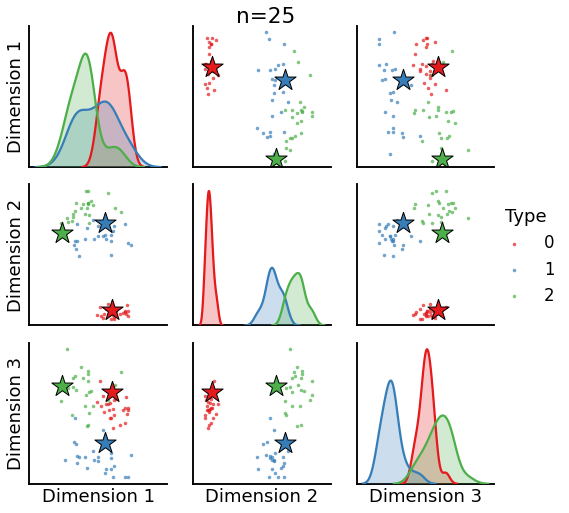

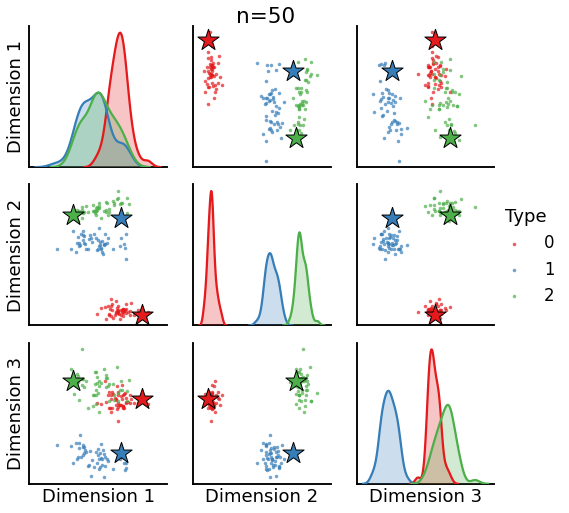

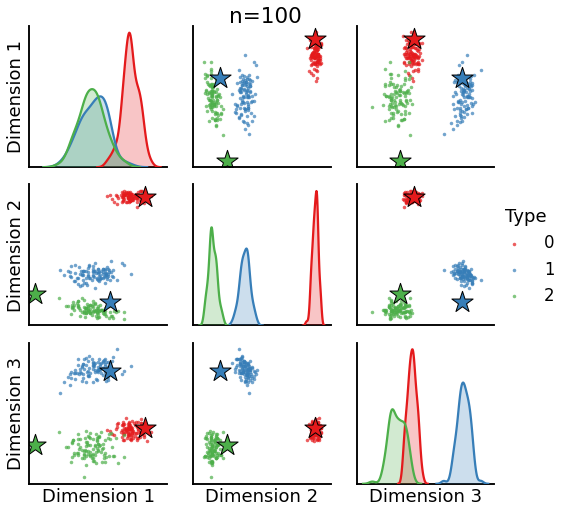

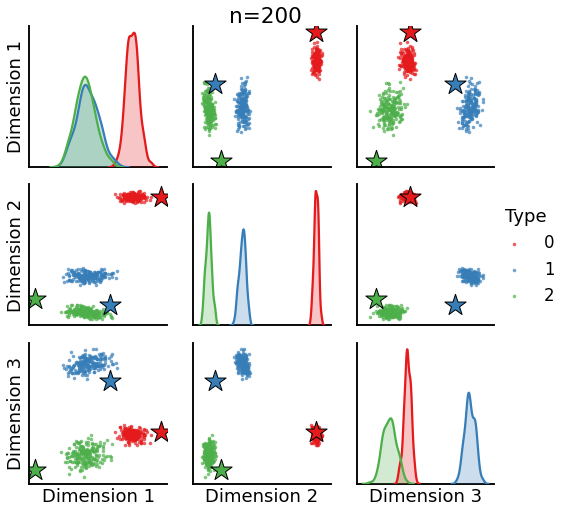

In [11]:
# P = np.array([[0.8, 0.3, 0.1], 
#               [0.3, 0.6, 0.1], 
#               [0.1, 0.1, 0.6]])

P = np.array([[0.9, 0.1, 0.1], 
              [0.3, 0.6, 0.1], 
              [0.1, 0.5, 0.6]])


for n in [25, 50, 100, 200]:
    graph(P, directed=True, diag_aug=False, suppress_text=True, n=n, title=f"n={n}")
    
print(np.linalg.eig(P))

(array([1.08844837, 0.58842506, 0.42312657]), array([[-0.59752807, -0.31739708, -0.13330639],
       [-0.49598508,  0.04154763, -0.30671662],
       [-0.63004683,  0.94738212,  0.9424194 ]]))


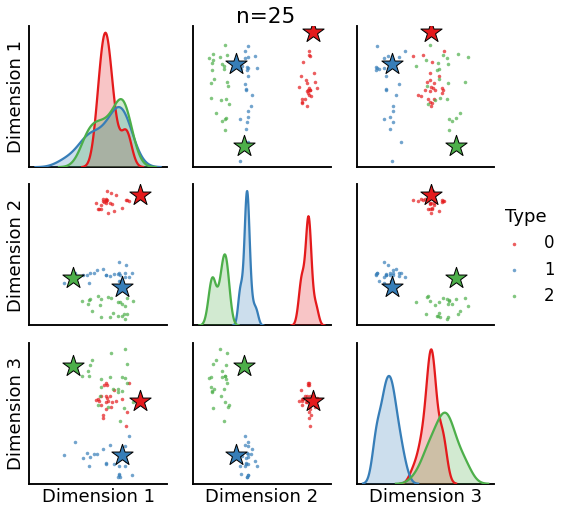

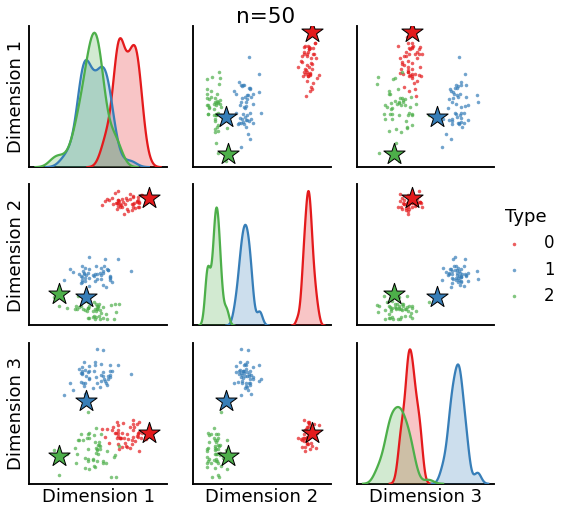

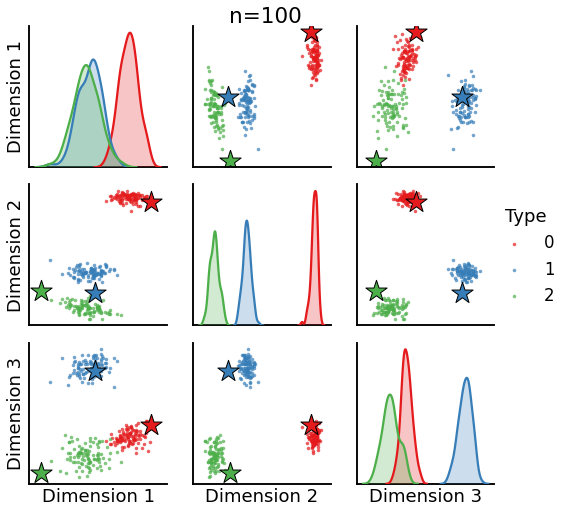

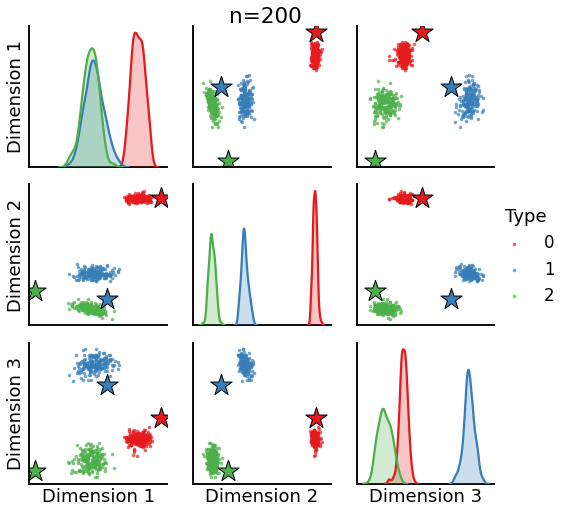

In [13]:
# P = np.array([[0.8, 0.3, 0.1], 
#               [0.3, 0.6, 0.1], 
#               [0.1, 0.1, 0.6]])

P = np.array([[0.9, 0.1, 0.1], 
              [0.3, 0.6, 0.1], 
              [0.1, 0.5, 0.6]])


for n in [25, 50, 100, 200]:
    graph(P, directed=True, diag_aug=False, reverse_pred=False, suppress_text=True, n=n, title=f"n={n}")
    
print(np.linalg.eig(P))